<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Part.3/7.ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 예제 7-1. ARIMA 오차 회귀 모델 예시

### 분기별 미국 소비 변화 ARIMA 오차 회귀 모델 적합

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 데이터 불러오기

In [2]:
us_change = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/us_change.csv")
us_change['observation_date'] = pd.to_datetime(us_change['observation_date'])
us_change.set_index('observation_date', inplace=True)
us_change['Consumption'] = us_change['PCEC'].pct_change()
us_change['Income'] = us_change['DPIC'].pct_change()
us_change['Production'] = us_change['Prod'].pct_change()
us_change['Savings'] = us_change['PSAVE'].pct_change()
us_change.drop(['PCEC', 'DPIC','Prod', 'PSAVE'], axis=1, inplace=True)
us_change.drop(us_change.index[0], inplace=True)
us_change= us_change[ (us_change.index.year < 2020) & (us_change.index.year >= 1960)]
us_change

,Consumption,Income,Production,Savings
observation_date,,,,
1960-01-01,0.010909,0.011542,0.060295,0.028103
1960-04-01,0.017906,0.006468,-0.021699,-0.045027
1960-07-01,-0.000247,0.001906,-0.016444,0.055469
1960-10-01,0.005715,-0.000414,-0.024109,-0.014182
1961-01-01,0.001485,0.009446,-0.015140,0.097914
...,...,...,...,...
2018-10-01,0.006927,0.009531,0.001505,0.106422
2019-01-01,0.003617,0.012297,-0.009508,0.157016
2019-04-01,0.014167,-0.000732,-0.005780,-0.105221


#### 데이터 시각화

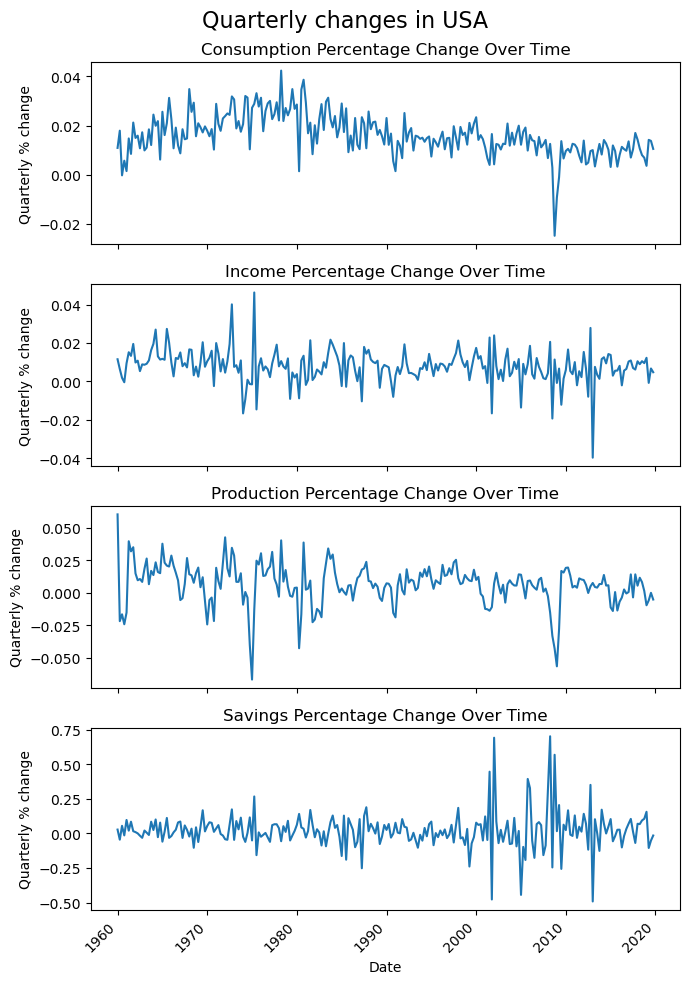

In [3]:
fig, axes = plt.subplots(us_change.shape[1], 1, figsize=(7, 10), sharex=True)

for i, var in enumerate(us_change.columns):
    axes[i].plot(us_change[var], label=var)
    axes[i].set_ylabel("Quarterly % change")
    axes[i].set_title(f'{var} Percentage Change Over Time')

axes[-1].set_xlabel('Date')
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')

plt.suptitle("Quarterly changes in USA", fontsize=16)
plt.tight_layout()
plt.show()

#### ARIMA 파라미터 최적화 함수

In [5]:
def ARIMAX_optimizer(y, X):
    result= []
    for p in range(4):
        for q in range(4):
            try:
                model = SARIMAX(y, X, order=(p, 0, q), simple_differencing=False).fit(dips=False)
            except:
                continue

            aic = model.aic
            result.append([p, q, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'q', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

#### 오차 차수 최적화

In [6]:
result = ARIMAX_optimizer(us_change["Consumption"], us_change[ ["Income", "Production", "Savings"] ])
result

,p,q,AIC
0,2,3,-1839.232635
1,1,3,-1830.268476
2,1,1,-1828.001279
3,1,2,-1825.812208
4,2,1,-1823.879774
5,3,0,-1821.400012
6,3,1,-1816.580155
7,2,0,-1809.222871
8,3,2,-1797.168159
9,3,3,-1796.889456


#### ARIMAX 모델 적합

In [7]:
model = SARIMAX(us_change["Consumption"], us_change[ ["Income", "Production", "Savings"] ], order=(2, 0, 3), simple_differencing=False)
fit = model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  240
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 928.616
Date:                Sun, 23 Feb 2025   AIC                          -1839.233
Time:                        15:32:08   BIC                          -1807.907
Sample:                    01-01-1960   HQIC                         -1826.611
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Income         0.4627      0.043     10.723      0.000       0.378       0.547
Production     0.1217      0.019      6.316      0.000       0.084       0.160
Savings       -0.0374      0.002    -17.797      0.000      -0.042      -0.033
ar.L1          0.1875      0.194      0.969      0.333      -0.192       0.567
ar.L2          0.7632      0.187      4.087      0.000       0.397       1.129
ma.L1          0.1188      0.202      0.588      0.557      -0.277       0.515
ma.L2         -0.4138      0.152     -2.724      0.006      -0.712      -0.116
ma.L3         -0.0703      0.079     -0.887      0.375      -0.225       0.085
sigma2      2.527e-05   2.11e-06     11.992      0.000    2.11e-05    2.94e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                27.99
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.29
Prob(H) (two-sided):                  0.67   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 잔차 확인

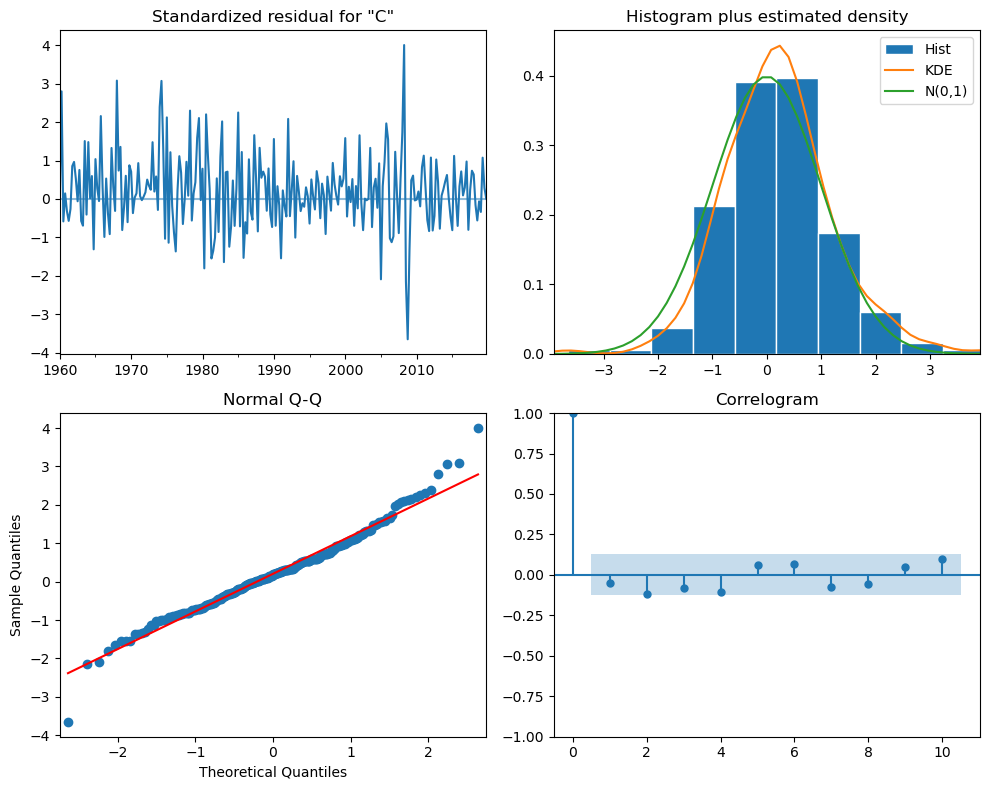

In [8]:
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

## 예제 7-2. ARIMA 오차 회귀 모델 예측

### 분기별 미국 소비 변화 ARIMA 오차 회귀 모델 예측

#### 필요한 패키지 불러오기

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 데이터 불러오기

In [10]:
us_change = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/us_change.csv")
us_change['observation_date'] = pd.to_datetime(us_change['observation_date'])
us_change.set_index('observation_date', inplace=True)
us_change['Consumption'] = us_change['PCEC'].pct_change()
us_change['Income'] = us_change['DPIC'].pct_change()
us_change['Production'] = us_change['Prod'].pct_change()
us_change['Savings'] = us_change['PSAVE'].pct_change()
us_change.drop(['PCEC', 'DPIC','Prod', 'PSAVE'], axis=1, inplace=True)
us_change.drop(us_change.index[0], inplace=True)
us_change= us_change[ (us_change.index.year < 2020) & (us_change.index.year >= 1960)]
us_change

,Consumption,Income,Production,Savings
observation_date,,,,
1960-01-01,0.010909,0.011542,0.060295,0.028103
1960-04-01,0.017906,0.006468,-0.021699,-0.045027
1960-07-01,-0.000247,0.001906,-0.016444,0.055469
1960-10-01,0.005715,-0.000414,-0.024109,-0.014182
1961-01-01,0.001485,0.009446,-0.015140,0.097914
...,...,...,...,...
2018-10-01,0.006927,0.009531,0.001505,0.106422
2019-01-01,0.003617,0.012297,-0.009508,0.157016
2019-04-01,0.014167,-0.000732,-0.005780,-0.105221


#### 예측 기간 설정 

In [11]:
forecast_horizon = 30

#### 오차 차수 최적화

In [13]:
result = ARIMAX_optimizer(us_change["Consumption"][:-forecast_horizon], us_change[ ["Income", "Production", "Savings"] ][:-forecast_horizon])
result

,p,q,AIC
0,2,3,-1587.623907
1,1,2,-1579.396036
2,2,1,-1578.195159
3,1,3,-1578.055624
4,1,1,-1576.710840
5,2,0,-1570.411033
6,3,0,-1567.503136
7,3,1,-1567.210950
8,3,3,-1553.114924
9,3,2,-1551.143582


#### ARIMAX모델 적합

In [14]:
model = SARIMAX(us_change["Consumption"][:-forecast_horizon], us_change[ ["Income", "Production", "Savings"] ][:-forecast_horizon], order=(2, 0, 3), simple_differencing=False)
fit = model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  210
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 802.812
Date:                Sun, 23 Feb 2025   AIC                          -1587.624
Time:                        15:32:21   BIC                          -1557.500
Sample:                    01-01-1960   HQIC                         -1575.446
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Income         0.4526      0.049      9.276      0.000       0.357       0.548
Production     0.1194      0.021      5.639      0.000       0.078       0.161
Savings       -0.0359      0.002    -15.227      0.000      -0.041      -0.031
ar.L1          0.1324      0.185      0.714      0.475      -0.231       0.496
ar.L2          0.8161      0.179      4.553      0.000       0.465       1.167
ma.L1          0.1842      0.194      0.951      0.342      -0.195       0.564
ma.L2         -0.4580      0.154     -2.979      0.003      -0.759      -0.157
ma.L3         -0.0508      0.086     -0.591      0.554      -0.219       0.118
sigma2      2.808e-05    2.6e-06     10.811      0.000     2.3e-05    3.32e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                15.80
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.23
Prob(H) (two-sided):                  0.86   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ARIMAX 예측

In [15]:
forecast_result = fit.get_forecast(forecast_horizon, exog=us_change[ ["Income", "Production", "Savings"] ].iloc[-forecast_horizon:])
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,1]

#### 예측 시각화

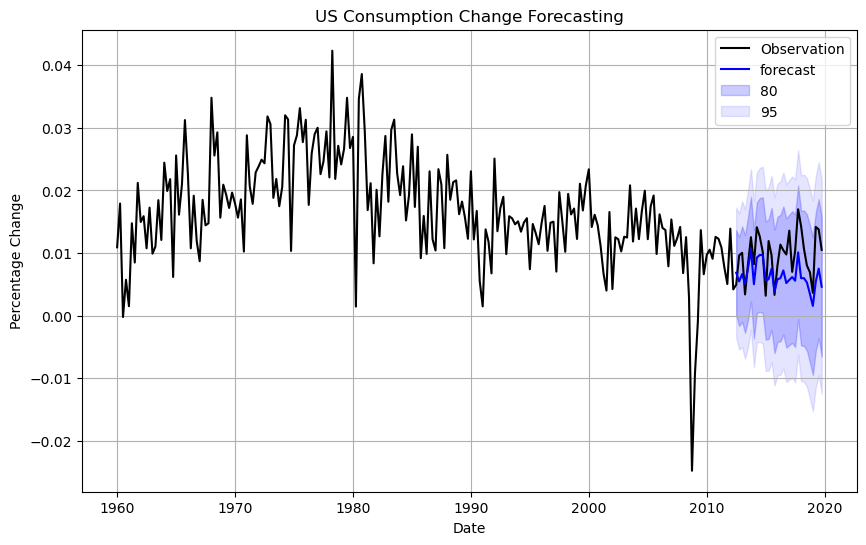

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(us_change["Consumption"], label='Observation', color='black')
plt.plot(forecast_mean, label='forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
plt.xlabel("Date")
plt.ylabel("Percentage Change")
plt.title("US Consumption Change Forecasting")
plt.grid(True)
plt.legend()
plt.show()

## 예제 7-3. 결정적 추세와 확률적 추세 예시

### 폴란드 수출량 데이터 결정적 추세와 확률적 추세를 활용한 예측

#### 필요한 패키지 불러오기

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 데이터 불러오기

In [18]:
global_economy = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')
pol_exports = global_economy[global_economy['Code'] == 'POL']
pol_exports.index = pol_exports['Year']
pol_exports

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
Year,,,,,,,,,
1960-01-01,Poland,POL,1960-01-01,NaN,NaN,NaN,NaN,NaN,29637450.0
1961-01-01,Poland,POL,1961-01-01,NaN,NaN,NaN,NaN,NaN,29964000.0
1962-01-01,Poland,POL,1962-01-01,NaN,NaN,NaN,NaN,NaN,30308500.0
1963-01-01,Poland,POL,1963-01-01,NaN,NaN,NaN,NaN,NaN,30712000.0
1964-01-01,Poland,POL,1964-01-01,NaN,NaN,NaN,NaN,NaN,31139450.0
1965-01-01,Poland,POL,1965-01-01,NaN,NaN,NaN,NaN,NaN,31444950.0
1966-01-01,Poland,POL,1966-01-01,NaN,NaN,NaN,NaN,NaN,31681000.0
1967-01-01,Poland,POL,1967-01-01,NaN,NaN,NaN,NaN,NaN,31987155.0
1968-01-01,Poland,POL,1968-01-01,NaN,NaN,NaN,NaN,NaN,32294655.0


#### 데이터 시각화

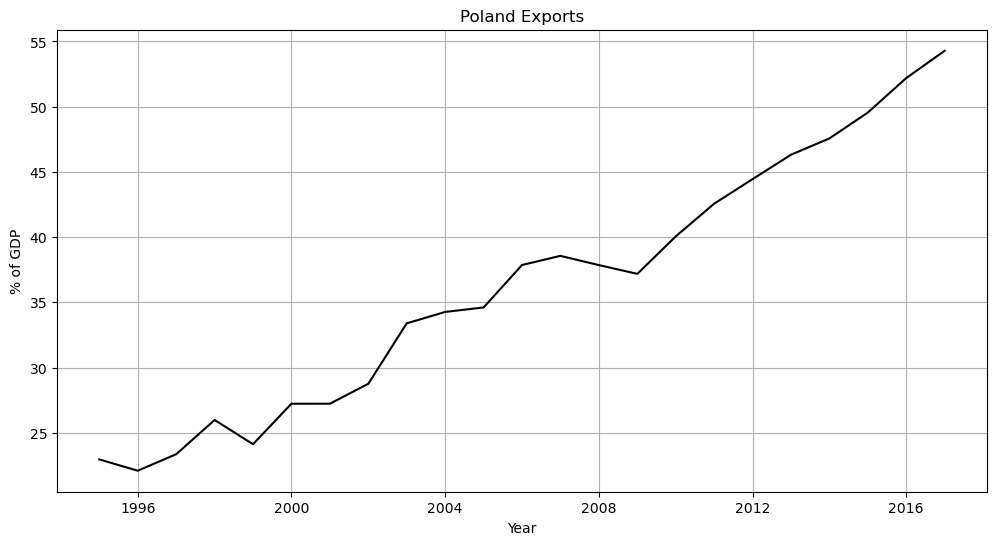

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(pol_exports['Exports'], color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Poland Exports')
plt.grid(True)
plt.show()

#### 결정적 추세 모델 적합

In [20]:
time_trend = np.arange(len(pol_exports))
model_deterministic = SARIMAX(pol_exports['Exports'], exog=time_trend, order=(1, 0, 0), trend='n', simple_differencing=False)
fit_deterministic = model_deterministic.fit(disp=False)

fit_deterministic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Exports   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -45.145
Date:                Sun, 23 Feb 2025   AIC                             96.289
Time:                        15:32:23   BIC                            102.471
Sample:                    01-01-1960   HQIC                            98.697
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9222      0.269      3.429      0.001       0.395       1.449
ar.L1          0.9724      0.089     10.893      0.000       0.797       1.147
sigma2         2.6148      1.029      2.541      0.011       0.598       4.631
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                16.28
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 확률적 추세 모델 적합

In [21]:
model_stochastic = SARIMAX(pol_exports['Exports'], order=(0, 1, 0), trend='c', simple_differencing=False)
fit_stochastic = model_stochastic.fit(disp=False)

fit_stochastic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Exports   No. Observations:                   58
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -48.690
Date:                Sun, 23 Feb 2025   AIC                            101.381
Time:                        15:32:23   BIC                            105.467
Sample:                    01-01-1960   HQIC                           102.969
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4240      0.336      4.237      0.000       0.765       2.083
sigma2         2.4035      0.835      2.878      0.004       0.767       4.040
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):                32.43
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 결정적 추세 모델 예측

In [22]:
future_trend = np.arange(len(pol_exports), len(pol_exports) + 20)
forecast_deterministic = fit_deterministic.get_forecast(steps=20, exog=future_trend)
forecast_deterministic_mean = forecast_deterministic.predicted_mean
forecast_deterministic_ci = forecast_deterministic.conf_int(alpha=0.05)

#### 확률적 추세 모델 예측

In [23]:
forecast_stochastic = fit_stochastic.get_forecast(steps=20)
forecast_stochastic_mean = forecast_stochastic.predicted_mean
forecast_stochastic_ci = forecast_stochastic.conf_int(alpha=0.05)

#### 예측 시각화

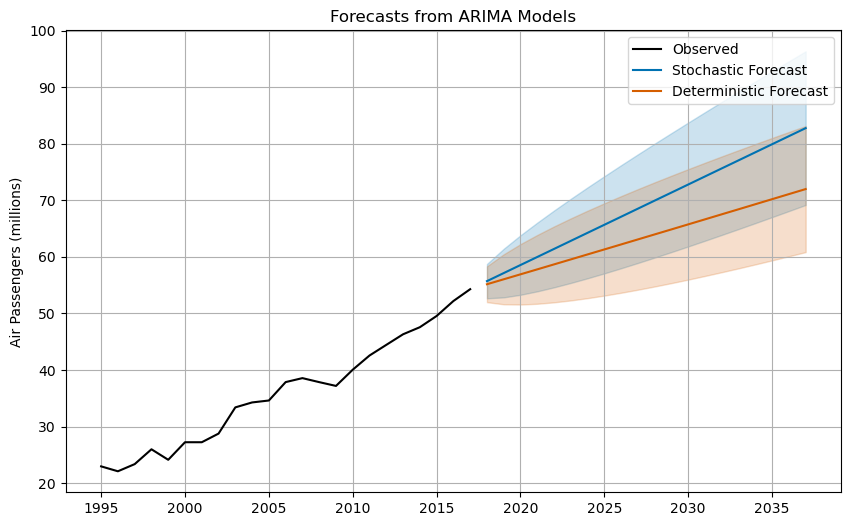

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(pol_exports.index, pol_exports['Exports'], label='Observed', color='black')

plt.plot(forecast_stochastic_mean, label='Stochastic Forecast', color='#0072B2')
plt.fill_between(forecast_stochastic_mean.index,
                 forecast_stochastic_ci.iloc[:, 0],
                 forecast_stochastic_ci.iloc[:, 1],
                 color='#0072B2', alpha=0.2)

plt.plot(forecast_deterministic_mean, label='Deterministic Forecast', color='#D55E00')
plt.fill_between(forecast_deterministic_mean.index,
                 forecast_deterministic_ci.iloc[:, 0],
                 forecast_deterministic_ci.iloc[:, 1],
                 color='#D55E00', alpha=0.2)

plt.title('Forecasts from ARIMA Models')
plt.legend()
plt.grid(True)
plt.show()

## 예제 7-4. 추세, 계절성 요소를 포함한 ARIMAX 모델 예시

### 소매 판매량 ARIMAX 모델 적합

#### 필요한 패키지 불러오기

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기

In [26]:
retail = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.3/data/example_retail_sales.csv")  
retail['ds'] = pd.to_datetime(retail['ds'])
retail['y'] = retail['y'].str.replace(",", "").astype(float)
retail.set_index('ds', inplace=True)
monthly_turnover = retail.groupby(retail.index)['y'].sum()
monthly_turnover = monthly_turnover.loc['2000-01-01':]
monthly_turnover

ds
2000-01-01    236422.0
2000-02-01    250580.0
2000-03-01    279515.0
2000-04-01    264417.0
2000-05-01    283706.0
                ...   
2024-06-01    701555.0
2024-07-01    726098.0
2024-08-01    733560.0
2024-09-01    683558.0
2024-10-01    730720.0
Name: y, Length: 298, dtype: float64

#### 데이터 시각화

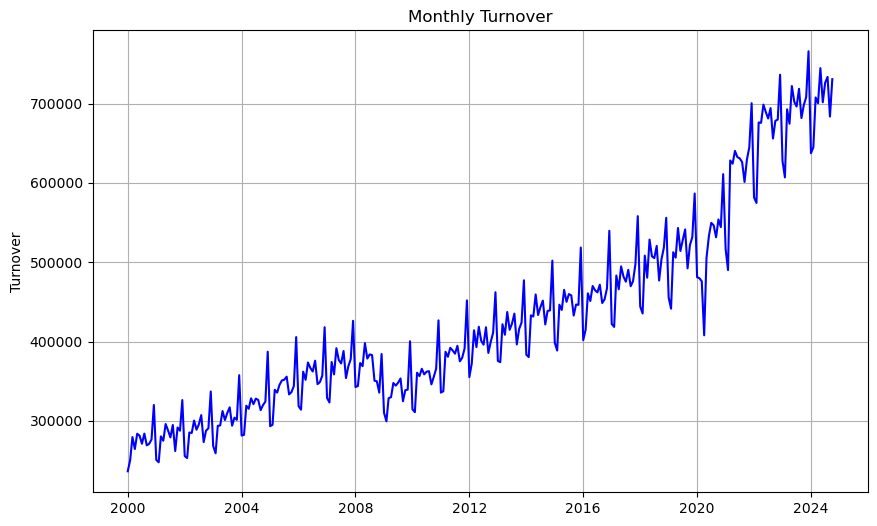

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_turnover,  color='b')
plt.ylabel('Turnover')
plt.title('Monthly Turnover')
plt.grid(True)
plt.show()

#### 푸리에 항 생성 함수

In [28]:
def fourier_series(x, K, period):
    n = len(x)
    t = np.arange(1, n + 1)
    results = pd.DataFrame(index=x.index)
    for k in range(1, K + 1):
        results[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        results[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return results

#### K에 따른 ARIMA 파라미터 사전 정의

In [29]:
arima_orders = {
    1: (2, 1, 3),
    2: (5, 1, 1),
    3: (3, 1, 1),
    4: (1, 1, 5),
    5: (2, 1, 0),
    6: (0, 1, 1)
}

#### 푸리에 오차 모델 적합 함수

In [30]:
def fit_arima_with_fourier(series, K, order):
    fourier_terms = fourier_series(monthly_turnover, K=K, period=12)

    model = SARIMAX(pd.Series(np.log(series), series.index), exog=fourier_terms, order=order, seasonal_order=(0, 0, 0, 12))
    return model.fit()

#### K에 따른 모델 적합

In [31]:
models = {}
aiccs = {}

for K in range(1, 7):
    arima_order = arima_orders[K] 
    model = fit_arima_with_fourier(monthly_turnover, K, arima_order)
    models[K] = model
    aiccs[K] = model.aicc

#### 예측 및 시각화

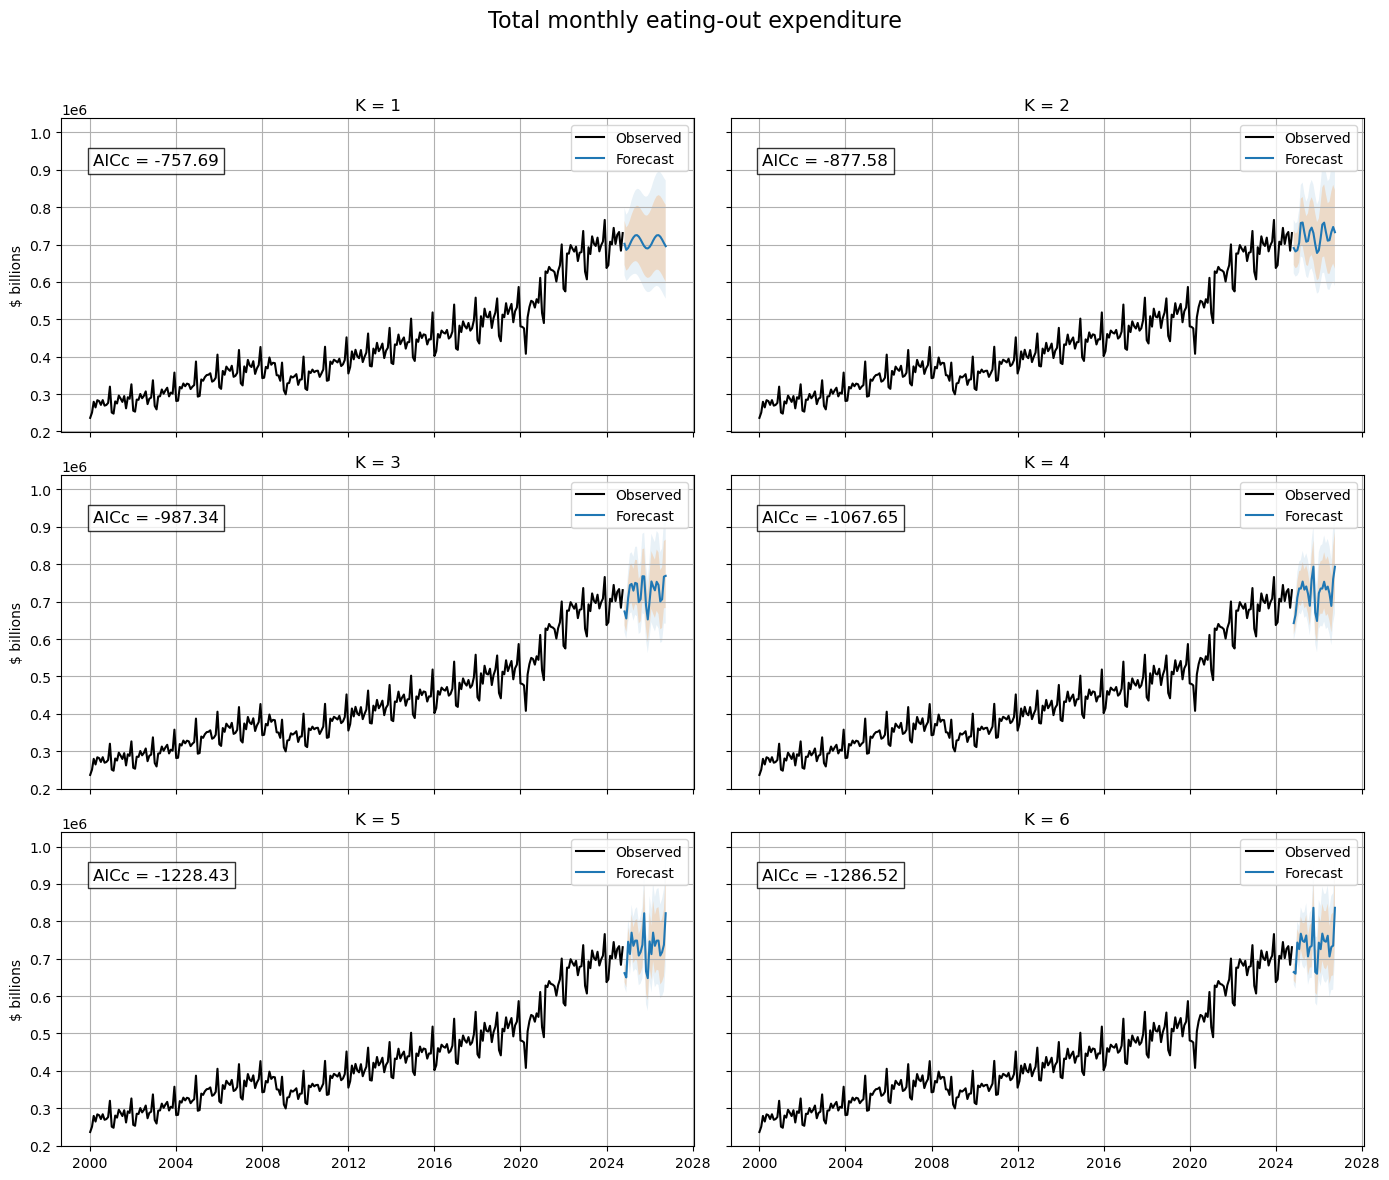

In [32]:
future_dates = pd.date_range(monthly_turnover.index[-1], periods=24 + 1, freq='M')[1:]

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (K, model) in enumerate(models.items()):
    ax = axes[i]

    ax.plot(monthly_turnover, label='Observed', color='black')

    future_fourier = fourier_series(pd.Series(future_dates), K=K, period=12)
    forecast_result = model.get_forecast(steps=24, exog=future_fourier)
    forecast_mean = np.exp(forecast_result.predicted_mean)
    ci95 = np.exp(forecast_result.conf_int(alpha=0.05))
    ci80 = np.exp(forecast_result.conf_int(alpha=0.2))
    ax.plot(forecast_mean, label=f'Forecast')
    ax.fill_between(forecast_mean.index, ci95.iloc[:, 0], ci95.iloc[:, 1], alpha=0.1)
    ax.fill_between(forecast_mean.index, ci80.iloc[:, 0], ci80.iloc[:, 1], alpha=0.2)

    ax.text(0.05, 0.85, f'AICc = {aiccs[K]:.2f}', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(f'K = {K}')
    if i % 2 == 0:
        ax.set_ylabel('$ billions')
    ax.legend()
    ax.grid(True)

plt.suptitle('Total monthly turnover', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()